/Users/xuantingdong/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


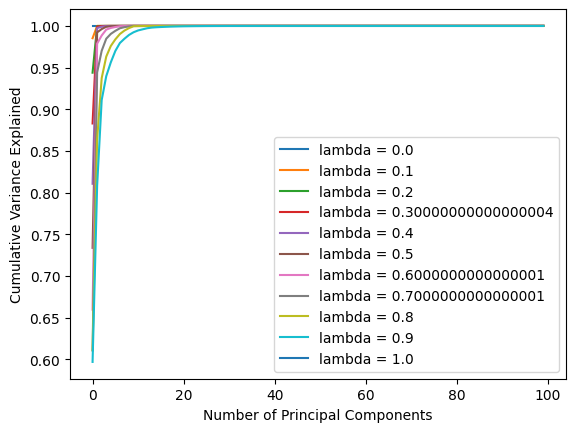

In [43]:
#Problem 1
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def exp_weighted_cov(X, alpha):
    n, p = X.shape
    mean = np.mean(X, axis=0)
    V = (1 - alpha) * np.outer(X[0] - mean, X[0] - mean)
    for i in range(1, n):
        V = (1 - alpha) * np.outer(X[i] - mean, X[i] - mean) + alpha * V
    return V / (n - 1)

df = pd.read_csv('DailyReturn.csv',header=0)
df = df.dropna()
df = df.iloc[:, 1:]

n_components = 100
lambdas = np.linspace(0, 1, 11)
cumulative_variance = []
for alpha in lambdas:
    covariance = exp_weighted_cov(df.values, alpha)
    pca = PCA(n_components=n_components)
    pca.fit(covariance)
    cumulative_variance.append(np.cumsum(pca.explained_variance_ratio_))

plt.figure()
for i in range(len(lambdas)):
    plt.plot(cumulative_variance[i], label='lambda = {}'.format(lambdas[i]))
plt.legend(loc='best')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()


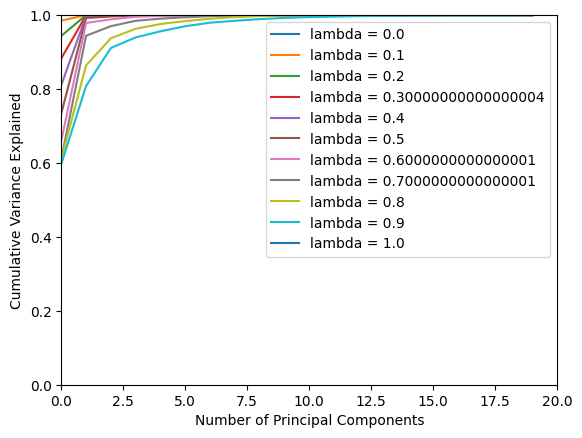

In [44]:
plt.figure()
for i in range(len(lambdas)):
    plt.plot(cumulative_variance[i][:20], label='lambda = {}'.format(lambdas[i]))
plt.legend(loc='best')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.show()


In [ ]:
#Problem 2
import numpy as np

#Transfer from julia
def chol_pd(a):
    n = a.shape[0]
    root = np.zeros((n, n))

    for j in range(n):
        s = 0.0
        if j > 0:
            s = np.dot(root[j, :j-1], root[j, :j-1])
        root[j, j] = np.sqrt(a[j, j] - s)
        ir = 1.0 / root[j, j]
        for i in range(j+1, n):
            s = np.dot(root[i, :j-1], root[j, :j-1])
            root[i, j] = (a[i, j] - s) * ir
    return root

def near_psd(a, epsilon=0.0):
    n = a.shape[0]
    invSD = None
    out = a.copy()
    
    if np.count_nonzero(np.diag(out) - 1.0) != n:
        invSD = np.diag(1 / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD
    
    vals, vecs = np.linalg.eigh(out)
    vals = np.maximum(vals, epsilon)
    T = 1 / (vecs * vecs * vals).sum(axis=1)
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = T @ vecs @ l
    out = B @ B.T
    
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        out = invSD @ out @ invSD
    
    return out


In [76]:
#Calculate the run time
import time

n = 500
sigma = 0.9 * np.ones((n, n))
np.fill_diagonal(sigma, 1.0)
sigma[1, 2] = 0.7357
sigma[2, 1] = 0.7357

def highams_method(matrix):
    e, v = np.linalg.eigh(matrix)
    e = np.maximum(e, 0)
    matrix = v @ np.diag(e) @ v.T
    return matrix

def near_psd(matrix, epsilon=0.0):
    n = matrix.shape[0]
    invSD = None
    mat = matrix.copy()

    if not np.allclose(np.diag(mat), np.ones(n)):
        invSD = np.diag(1 / np.sqrt(np.diag(mat)))
        mat = invSD @ mat @ invSD
    
    vals, vecs = np.linalg.eigh(mat)
    vals = np.maximum(vals, epsilon)
    T = 1 / (vecs * vecs * vals)
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = T @ vecs @ l
    mat = B @ B.T
    
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        mat = invSD @ mat @ invSD
    return mat

def frobenius_norm(matrix1, matrix2):
    return np.linalg.norm(matrix1 - matrix2, ord='fro')

start = time.time()
highams = highams_method(sigma)
end = time.time()
highams_time = end - start

start = time.time()
near_psd_matrix = near_psd(sigma)
end = time.time()
near_psd_time = end - start

print("Frobenius norm of difference between original and Higham's corrected matrix:", frobenius_norm(sigma, highams))
print("Frobenius norm of difference between original and near_PSD corrected matrix:", frobenius_norm(sigma, near_psd_matrix))
print("Time taken by Higham's method:", highams_time)
print("Time taken by near_PSD method:", near_psd_time)


Frobenius norm of difference between original and Higham's corrected matrix: 0.06364303890468642
Frobenius norm of difference between original and near_PSD corrected matrix: nan
Time taken by Higham's method: 0.11989974975585938
Time taken by near_PSD method: 0.08477473258972168


/var/folders/84/_nb6p8gs52vbj2zb1fpgrm2h0000gn/T/ipykernel_53864/1865086215.py:28: RuntimeWarning: divide by zero encountered in divide
  T = 1 / (vecs * vecs * vals)
/var/folders/84/_nb6p8gs52vbj2zb1fpgrm2h0000gn/T/ipykernel_53864/1865086215.py:31: RuntimeWarning: invalid value encountered in matmul
  B = T @ vecs @ l


In [83]:
#Problem 3

import numpy as np

def multivariate_normal(mean, cov, size=1, pca=False, explained_variance=None):
    if pca:
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        if explained_variance is not None:
            explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
            n_components = np.searchsorted(explained_variance, explained_variance) + 1

            eigenvalues = eigenvalues[:n_components]
            eigenvectors = eigenvectors[:, :n_components]

        X = np.random.normal(size=(size, eigenvectors.shape[0]))
        X = X @ np.diag(np.sqrt(eigenvalues)) @ eigenvectors.T

        X = X + mean

        return X
    else:
        return np.random.multivariate_normal(mean, cov, size)


In [87]:
import numpy as np
import pandas as pd
def simulate_multivariate_normal(mean, cov, size=25000, pca=False, explained_variance=None, n=20):
    if pca:
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        
        indices = np.argsort(-eigenvalues)
        eigenvalues = eigenvalues[indices]
        eigenvectors = eigenvectors[:, indices]
        
        eigenvalues = eigenvalues[:n]
        eigenvectors = eigenvectors[:, :n]
        
        X = np.random.normal(size=(size, eigenvectors.shape[0]))
        X = X @ np.diag(np.sqrt(eigenvalues)) @ eigenvectors.T
    else:
        X = np.random.multivariate_normal(mean, cov, size=size)
    
    X = X + mean
    
    return X


def generate_correlation_matrix_and_variance(X, method='pearson', decay_rate=0.97):
    if method == 'pearson':
        corr = np.corrcoef(X, rowvar=False)

        var = np.var(X, axis=0)

    elif method == 'exponentially_weighted':
        n = X.shape[0]
        cov = np.zeros((X.shape[1], X.shape[1]))
        for i in range(n):
            cov = decay_rate * cov + (1 - decay_rate) * np.outer(X[i], X[i])

        var = np.diag(cov)

        stddev = np.sqrt(var)
        corr = cov / np.outer(stddev, stddev)

    return corr, var

df = pd.read_csv('DailyReturn.csv',header=0)
df = df.dropna()
df = df.iloc[:, 1:]

corr, var = generate_correlation_matrix_and_variance(df.values, method='pearson')
cov_pearson = np.diag(var) * corr
corr, var = generate_correlation_matrix_and_variance(df.values, method='exponentially_weighted')
cov_exp_weighted = np.diag(var) * corr

mean = df.mean().values
covs = [cov_pearson, cov_exp_weighted]
explained_variances = [None, 1, 0.75, 0.5]

for cov in covs:
    for explained_variance in explained_variances:
        X = simulate_multivariate_normal(mean, cov, pca=explained_variance is not None, explained_variance=explained_variance, n=df.shape[1])
        
        cov_sim = np.cov(X.T)
        
        print(f"Original covariance matrix:\n{cov}")
        print(f"Covariance of the simulated values:\n{cov_sim}")



Original covariance matrix:
[[7.71482917e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.53165588e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.50553256e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.17531002e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.96328665e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.72803673e-04]]
Covariance of the simulated values:
[[ 7.70347218e-05 -1.24630434e-07  1.05262565e-06 ... -3.33067061e-07
  -1.54216892e-06  3.97840554e-07]
 [-1.24630434e-07  2.57313787e-04 -1.65630171e-06 ...  2.80697615e-06
   3.29311141e-06 -1.21443518e-06]
 [ 1.05262565e-06 -1.65630171e-06  2.52975052e-04 ...  1.31718340e-06
   8.78368661e-07  4.25745594e-07]
 ...
 [-3.33067061e-0

In [88]:
def compare_covariances(cov, cov_sim):
    return np.linalg.norm(cov - cov_sim)

frobenius_norms = []
for cov in covs:
    for explained_variance in explained_variances:
        X = simulate_multivariate_normal(mean, cov, pca=explained_variance is not None, explained_variance=explained_variance, n=df.shape[1])
        cov_sim = np.cov(X.T)
        frobenius_norms.append(compare_covariances(cov, cov_sim))

print("Frobenius norms:", frobenius_norms)


Frobenius norms: [0.00021544402308902835, 0.0002250823056869961, 0.0002128785894683783, 0.0002168326272680415, 0.0001832409879694117, 0.00019203926494970076, 0.0001898032266604145, 0.00018572857704194197]


In [89]:
import time

run_times = []
for cov in covs:
    for explained_variance in explained_variances:
        start = time.time()
        X = simulate_multivariate_normal(mean, cov, pca=explained_variance is not None, explained_variance=explained_variance, n=df.shape[1])
        end = time.time()
        run_times.append(end - start)

print("Run times:", run_times)


Run times: [0.07155871391296387, 0.0768437385559082, 0.08999085426330566, 0.11965370178222656, 0.07186508178710938, 0.12430787086486816, 0.11174392700195312, 0.09237480163574219]
